In [173]:
using Graphs
using Plots
using LinearAlgebra
using Statistics
include("../sis.jl")
include("../mpdbp.jl")
include("../exact/montecarlo.jl")
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

In [213]:
q = q_sis
T = 10
N = 20
k = 3
gg = random_regular_graph(N, k)
g = IndexedGraph(gg)
λ = 0.25
κ = 0.25
γ = 2/N
p⁰ = map(1:N) do i
    [1-γ, γ]
end

# # throw random observations
# nobs_node = 10
# its = rand(collect(Iterators.product(1:N, 1:T)), nobs_node)
# for (i, t) in its
#     r = rand()
#     ϕ[i][t] .= [r, 1-r]
# end

# # throw random pair observations
# nobs_edge = 10
# its = rand(collect(Iterators.product(edges(g), 1:T)), nobs_edge)
# O = map(its) do (e,t)
#     i, j, ij = e
#     (i, j, t, rand(2,2))
# end

# ψ = pair_observations_directed(O, IndexedBiDiGraph(gg), T, q)

# sis = SIS(g, λ, κ, p⁰, ϕ, ψ);
sis = SIS(g, λ, κ, T; p⁰);

In [221]:
bp = mpdbp(sis, d=1)
cb = CB_BP(bp);

In [222]:
nobs_node = N÷2
draw_node_observations!(bp, nobs_node; last_time=true);

In [223]:
# svd_trunc = TruncThresh(1e-2)
svd_trunc = TruncBond(3)
iters, cb = iterate!(bp, maxiter=500; svd_trunc, cb, tol=1e-4);

Running MPdBP: iter 20 	 Time: 0:00:11
  Δ:  9.604186531503994e-5

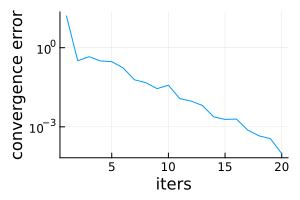

In [224]:
pl_err = plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="")

In [228]:
b_bp = beliefs(bp)
p_bp = [[bbb[2] for bbb in bb] for bb in b_bp];

In [226]:
ns = 5*10^5
sms = sample(bp, ns)
b_mc = marginals(sms)
p_mc = [[bbb[2] for bbb in bb] for bb in b_mc];

SoftMargin sampling... 100%|█████████████████████████████| Time: 0:01:00


SIS on random regular graph N=20, k=3. P(S→I)=0.25, P(I→S)=0.25.
Max matrix size: 3x3


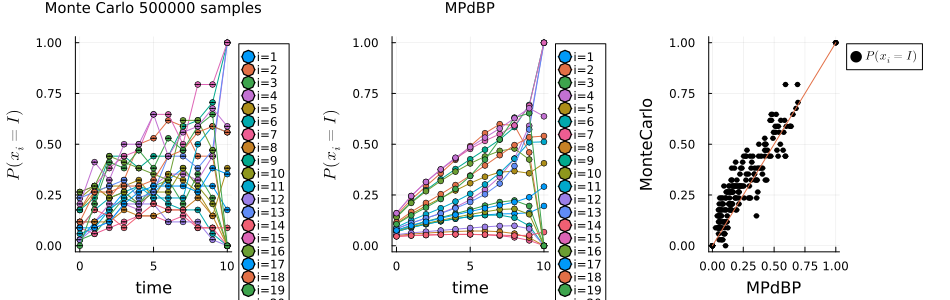

In [229]:
pl_mc = plot(xlabel="time", ylabel="\$P(x_i=I)\$", xticks=0:5:T, title="Monte Carlo $ns samples")
for i in 1:N
    plot!(pl_mc, 0:T, p_mc[i], label="i=$i", m=:o, ms=3, lw=1)
end
pl_bp = plot(xlabel="time", ylabel="\$P(x_i=I)\$", xticks=0:5:T, title="MPdBP")
for i in 1:N
    plot!(pl_bp, 0:T, p_bp[i], label="i=$i", m=:o, ms=3, lw=1)
end
pl_sc = scatter(reduce(vcat, p_bp), reduce(vcat, p_mc), xlabel="MPdBP", ylabel="MonteCarlo", 
    label="\$P(x_i=I)\$", ms=3, c=:black, legend=:outertopright)
plot!(identity, label="", size=(300,300))
println("SIS on random regular graph N=$N, k=$k. P(S→I)=$λ, P(I→S)=$κ.")
# println("$nobs_node random node observations, $nobs_edge random edge observations")
println("Max matrix size: ", svd_trunc.mprime, "x", svd_trunc.mprime)
plot(pl_mc, pl_bp, pl_sc, titlefontsize=10, size=(950, 300), legend=:outertopright, 
    margin=5Plots.mm, layout=(1,3))